# Data Mining project

In [1]:
# EP, NG, AP
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('customer_supermarket.csv', sep='\t', index_col=0)
df = df.drop_duplicates()

In [3]:
print(df.head())

  BasketID      BasketDate  Sale  CustomerID CustomerCountry  ProdID  \
0   536365  01/12/10 08:26  2,55     17850.0  United Kingdom  85123A   
1   536365  01/12/10 08:26  3,39     17850.0  United Kingdom   71053   
2   536365  01/12/10 08:26  2,75     17850.0  United Kingdom  84406B   
3   536365  01/12/10 08:26  3,39     17850.0  United Kingdom  84029G   
4   536365  01/12/10 08:26  3,39     17850.0  United Kingdom  84029E   

                             ProdDescr  Qta  
0   WHITE HANGING HEART T-LIGHT HOLDER    6  
1                  WHITE METAL LANTERN    6  
2       CREAM CUPID HEARTS COAT HANGER    8  
3  KNITTED UNION FLAG HOT WATER BOTTLE    6  
4       RED WOOLLY HOTTIE WHITE HEART.    6  


### Types checking and basic statistics

In [3]:
df.dtypes

BasketID            object
BasketDate          object
Sale                object
CustomerID         float64
CustomerCountry     object
ProdID              object
ProdDescr           object
Qta                  int64
dtype: object

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 466678 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   BasketID         466678 non-null  object 
 1   BasketDate       466678 non-null  object 
 2   Sale             466678 non-null  object 
 3   CustomerID       401605 non-null  float64
 4   CustomerCountry  466678 non-null  object 
 5   ProdID           466678 non-null  object 
 6   ProdDescr        465925 non-null  object 
 7   Qta              466678 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 32.0+ MB


In [5]:
df.isnull().any()

BasketID           False
BasketDate         False
Sale               False
CustomerID          True
CustomerCountry    False
ProdID             False
ProdDescr           True
Qta                False
dtype: bool

In [6]:
df.describe()

,CustomerID,Qta
count,401605.000000,466678.000000
mean,15281.154341,10.806528
std,1714.008869,232.627771
min,12346.000000,-80995.000000
25%,13939.000000,2.000000
50%,15145.000000,4.000000
75%,16784.000000,12.000000
max,18287.000000,80995.000000


#### Fixing 'Sale':
* Replace commas with dots
* Cast it into a float field

Check if any element of 'Sale' contains letters


In [4]:
import string
for elem in df['Sale']:
    for c in elem:
        if c in string.ascii_letters:
            print(elem)
            break

The attribute 'Sale' does not contain any null value or letters, only numbers,
but we need to substitute commas with dots and cast the filed into float

In [4]:
df['Sale'].replace(to_replace=r'(\d+),(\d*)', value=r'\1.\2', regex=True, inplace=True)
print('Changed commas into dots:')
print(df['Sale'][0 : 5])
df['Sale'] = df['Sale'].astype(float)
print('\nChanged type into float64:')
df.info()

Changed commas into dots:
0    2.55
1    3.39
2    2.75
3    3.39
4    3.39
Name: Sale, dtype: object

Changed type into float64:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 466678 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   BasketID         466678 non-null  object 
 1   BasketDate       466678 non-null  object 
 2   Sale             466678 non-null  float64
 3   CustomerID       401605 non-null  float64
 4   CustomerCountry  466678 non-null  object 
 5   ProdID           466678 non-null  object 
 6   ProdDescr        465925 non-null  object 
 7   Qta              466678 non-null  int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 32.0+ MB


In [5]:
print("Sale values")
print("TOT : ", len(df['Sale']))
print(" < 0: ", len(df[df['Sale'] < 0]))
print(" > 100: ", len(df[df['Sale'] > 100]))
print(" > 1000: ", len(df[df['Sale'] > 1000]))

Sale values
TOT :  466678
 < 0:  2
 > 100:  634
 > 1000:  84


#### Checking 'BasketID':

In [ ]:
counter = 0
for index, row in df.iterrows():
    if row['BasketID'][0] == 'C' and row['Qta'] >= 0:
        counter += 1
print('Number of rows with BasketID starting with "C" and positive Qta: ', counter)

Every BaskedID starting with "C" is associated with a negative value in the Qta attrbute

#### Checking 'CustomerID':

* Check if NaN CustomerIDs can be associated to a valid value through their BasketID

In [7]:
# check if the decimal part is always 0
counter = 0
for elem in df['CustomerID']:
    if elem % 1.0 != 0.0 and not pd.isnull(elem):
        counter += 1
print('Number of CustomerIDs with decimal part != 0: ', counter)

Number of CustomerIDs with decimal part != 0:  0


Substitute null CustomerIDs by the id found in a recordo with the same BasketID
(super slow to run)

In [8]:
# Fixing null CustomerIDs
bad_rows_indeces = []
for i in range(len(df)):
    row = df.iloc[i]
    if pd.isnull(row['CustomerID']):
        if not pd.isnull(row['BasketID']):
            basketID = row['BasketID']
            for j in range(min(0, i-10), min(i+10, len(df))):
                if df.iloc[j]['BasketID'] == basketID:
                    row['CustomerID'] = df.iloc[j]['CustomerID']
                    break
        else:
            print(f"\nRow {i} is a bad row")
            bad_rows_indeces.append(i)

print("For the following rows it wasn't possible to find the CustomerID: ", bad_rows_indeces)

<ipython-input-8-b68daaad6656>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row['CustomerID'] = df.iloc[j]['CustomerID']


KeyboardInterrupt: 

In [6]:
# Drop rows with null CustomerID (if the prev method doesn't work)
df.drop(df[~df['CustomerID'].notnull()].index, inplace=True)
df.isnull().any()

BasketID           False
BasketDate         False
Sale               False
CustomerID         False
CustomerCountry    False
ProdID             False
ProdDescr          False
Qta                False
dtype: bool

In [ ]:
df['CustomerID'] = df['CustomerID'].astype(int)
df.info()

#### Checking 'Qta':

In [25]:
print("Quantity values")
print("TOT entries: ", len(df['Qta']))
print(" < 0: ", len(df[df['Qta'] < 0]))
print(" > 100: ", len(df[df['Qta'] > 100]))
print(" > 1000: ", len(df[df['Qta'] > 1000]))
print('\n')

Quantity values
TOT entries:  401605
 < 0:  8872
 > 100:  4663
 > 1000:  105




Most bought products with a **negative** quantity:

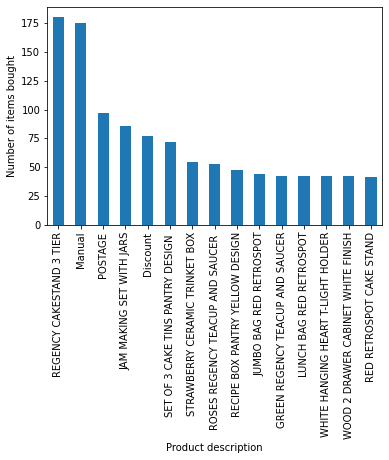

In [7]:
df_negQta = df[df['Qta'] < 0]
df_negQta['ProdDescr'].value_counts()[ : 15].plot(kind='bar')
plt.xlabel('Product description')
plt.ylabel('Number of items bought')
plt.show()

This analysis does not show any plausible reason for a negative quantity

Check how many BasketIDs associated with a negative quantity do not start with "C":

In [8]:
count = 0
for index, row in df[df['Qta'] < 0].iterrows():
    if row['BasketID'][0] != 'C':
        count += 1
print(f"{count} rows associated with a negative quantity have a BasketID NOT starting with 'C'")

0 rows associated with a negative quantity have a BasketID NOT starting with 'C'


Needed further analysis on rows having a BasketID starting with "C", because they also have a negative Qta

In [20]:
df['CustomerCountry'].value_counts()

United Kingdom          356728
Germany                   9480
France                    8476
EIRE                      7475
Spain                     2528
Netherlands               2371
Belgium                   2069
Switzerland               1877
Portugal                  1471
Australia                 1258
Norway                    1086
Italy                      803
Channel Islands            757
Finland                    695
Cyprus                     611
Sweden                     461
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
USA                        291
Israel                     247
Unspecified                241
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon                     45
Lithuani